## 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 정규방정식을 이용한 선형회귀

In [2]:
# 정규방정식을 테스트해 보기 위해 선형처럼 보이는 데이터를 생성한다

import numpy as np

X = 2 * np.random.rand(100, 1)  # 100x1 크기의 0~1 사이의 값으로 이루어진 값을 리턴
y = 4 + 3 * X + np.random.randn(100, 1)  # 100x1 크기의 정규분포를 따르는 값을 리턴

.rand() : Random values in a given shape  
.randn() : Return a sample from the "standard normal" distribution

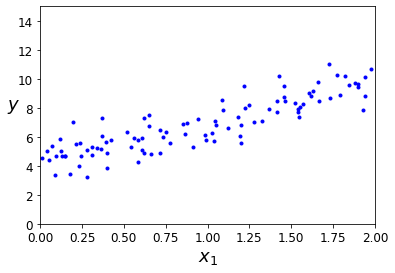

In [3]:
# 그래프 그리기

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [4]:
# 선형 데이터를 생성했고 이제 정규방정식을 이용해 세타^hat을 계산한다

X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0=1을 추가한다
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
# 구한 세타 출력해 보기

theta_best

array([[4.21509616],
       [2.77011339]])

이 데이터를 생성하기 위해 사용한 함수는 y = 4 + 3x + 가우시안_잡음 이었다.  
즉 세타0 = 4, 세타1 = 3이 나오길 기대했는데 잡음 떄문에 원래 함수의 파라미터를 정확하게 재현하지 못했다.  
구한 세타^ 을 사용해 예측을 해보자 <- (y^ = X세타^)

In [6]:
# 구한 세타^hat 을 사용해 예측을 해보자

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0=1을 추가한다
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

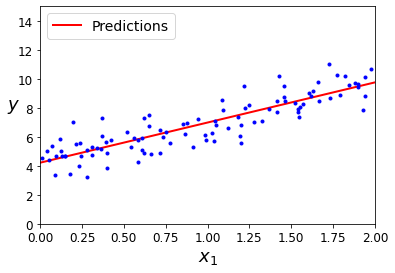

In [7]:
# 모델의 예측을 그래프로 나타내자

plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
# 사이킷 런에서 선형 회귀를 수행한다

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_  # .intercept_(편향), .coef_(가중치)

(array([4.21509616]), array([[2.77011339]]))

In [9]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

LinearRegression 클래스는 scipy.linalg.lstsq() 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있습니다:

In [10]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

# 앞에서 한 정규방정식 대체 ?~?

array([[4.21509616],
       [2.77011339]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산합니다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 유사역행렬 (pseudoinverse)입니다(Moore–Penrose 유사역행렬입니다). np.linalg.pinv()을 사용해서 유사역행렬을 직접 계산할 수 있습니다:

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 배치 경사 하강법을 사용한 선형 회귀

In [12]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)  # 초기값은 랜덤으로 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [13]:
theta

array([[4.21509616],
       [2.77011339]])

In [14]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [15]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

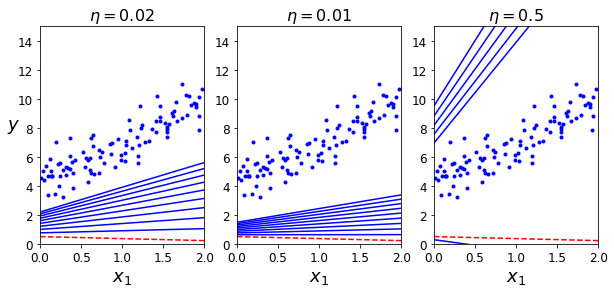

In [16]:
np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize = (10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta = 0.02)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(132); plot_gradient_descent(theta, eta = 0.01, theta_path = theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta = 0.5)

plt.show()

## 확률적 경사 하강법

In [17]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

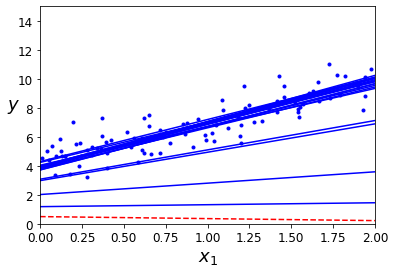

In [18]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [19]:
theta

array([[4.21076011],
       [2.74856079]])

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1, random_state = 42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_
# 결과를 보면 정규방정식으로 구한 것과 매우 비슷하다.

(array([4.24365286]), array([2.8250878]))

## 미니배치 경사 하강법

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffeled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffeled[i:i + minibatch_size]
        yi = y_shuffled[i:i + minibatch_size]
        gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


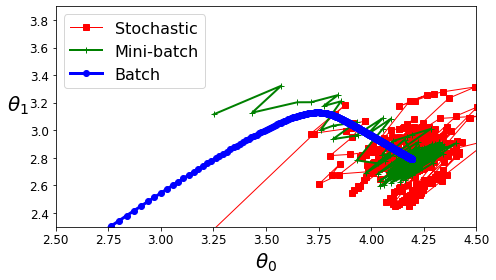

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()